In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.8335 - acc: 0.1120
Epoch 00001: val_loss improved from inf to 2.95988, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_1_conv_checkpoint/001-2.9599.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 3.8334 - acc: 0.1121 - val_loss: 2.9599 - val_acc: 0.1181
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2207 - acc: 0.3617
Epoch 00002: val_loss did not improve from 2.95988
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.2207 - acc: 0.3617 - val_loss: 3.5495 - val_acc: 0.1174
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7676 - acc: 0.4803
Epoch 00003: val_loss did not improve from 2.95988
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.7676 - acc: 0.4803 - val_loss: 3.9101 - v

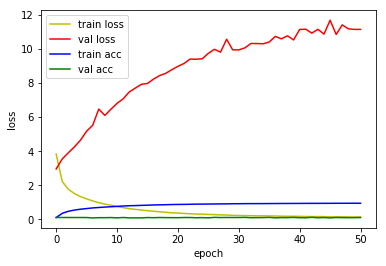

4815/4815 [==============================] - 2s 425us/sample - loss: 2.9525 - acc: 0.1111
Loss: 2.9524691781769907 Accuracy: 0.11111111

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0360 - acc: 0.2314
Epoch 00001: val_loss improved from inf to 2.76164, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_2_conv_checkpoint/001-2.7616.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 3.0359 - acc: 0.2314 - val_loss: 2.7616 - val_acc: 0.2860
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0439 - acc: 0.4479
Epoch 00002: val_loss did not improve from 2.76164
36805/36805 [==============================] - 71s 2ms/sample - loss: 2.0438 - acc: 0.4479 - val_loss: 3.4273 - val_acc: 0.2721
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5031 - acc: 0.5733
Epoch 00003: val_loss did not improve from 2.76164
36805/36805 [===========

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1314 - acc: 0.9659
Epoch 00030: val_loss did not improve from 2.76164
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.1314 - acc: 0.9659 - val_loss: 5.6780 - val_acc: 0.4014
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1444 - acc: 0.9633
Epoch 00031: val_loss did not improve from 2.76164
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.1445 - acc: 0.9632 - val_loss: 5.8556 - val_acc: 0.3785
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1521 - acc: 0.9599
Epoch 00032: val_loss did not improve from 2.76164
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.1521 - acc: 0.9599 - val_loss: 6.3250 - val_acc: 0.3527
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1397 - acc: 0.9644
Epoch 00033: val_loss did not improve from 2.76164
36805/36805 [===========

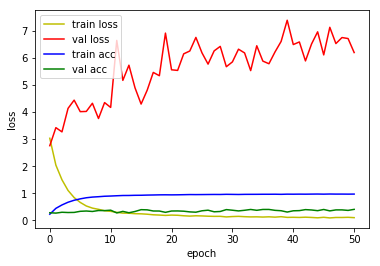

4815/4815 [==============================] - 3s 714us/sample - loss: 2.8602 - acc: 0.2675
Loss: 2.86019342042204 Accuracy: 0.2674974

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2421 - acc: 0.3445
Epoch 00001: val_loss improved from inf to 1.74291, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_3_conv_checkpoint/001-1.7429.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.2420 - acc: 0.3444 - val_loss: 1.7429 - val_acc: 0.4761
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4364 - acc: 0.5655
Epoch 00002: val_loss did not improve from 1.74291
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.4367 - acc: 0.5654 - val_loss: 1.7924 - val_acc: 0.4833
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0877 - acc: 0.6665
Epoch 00003: val_loss did not improve from 1.74291
36805/36805 [==============

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0870 - acc: 0.9745
Epoch 00030: val_loss did not improve from 1.60379
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0870 - acc: 0.9745 - val_loss: 2.8291 - val_acc: 0.5392
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0946 - acc: 0.9728
Epoch 00031: val_loss did not improve from 1.60379
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0947 - acc: 0.9727 - val_loss: 4.3035 - val_acc: 0.4020
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0895 - acc: 0.9742
Epoch 00032: val_loss did not improve from 1.60379
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0895 - acc: 0.9742 - val_loss: 2.6682 - val_acc: 0.5672
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9736
Epoch 00033: val_loss did not improve from 1.60379
36805/36805 [===========

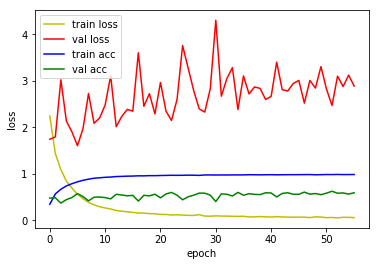

4815/4815 [==============================] - 4s 829us/sample - loss: 1.7496 - acc: 0.5350
Loss: 1.7496076897297321 Accuracy: 0.5349948

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0239 - acc: 0.3820
Epoch 00001: val_loss improved from inf to 1.51531, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_4_conv_checkpoint/001-1.5153.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 2.0242 - acc: 0.3820 - val_loss: 1.5153 - val_acc: 0.5134
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3830 - acc: 0.5769
Epoch 00002: val_loss did not improve from 1.51531
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.3830 - acc: 0.5769 - val_loss: 1.8105 - val_acc: 0.4878
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1349 - acc: 0.6542
Epoch 00003: val_loss improved from 1.51531 to 1.38651, saving model to mode

36800/36805 [============================>.] - ETA: 0s - loss: 0.1671 - acc: 0.9499
Epoch 00029: val_loss did not improve from 1.14857
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1672 - acc: 0.9499 - val_loss: 2.0296 - val_acc: 0.5970
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1701 - acc: 0.9476
Epoch 00030: val_loss did not improve from 1.14857
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1701 - acc: 0.9476 - val_loss: 1.5284 - val_acc: 0.6739
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1652 - acc: 0.9498
Epoch 00031: val_loss did not improve from 1.14857
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1651 - acc: 0.9498 - val_loss: 2.0549 - val_acc: 0.6096
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1480 - acc: 0.9568
Epoch 00032: val_loss did not improve from 1.14857
36805/36805 [========================

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0818 - acc: 0.9768
Epoch 00059: val_loss did not improve from 1.14857
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0818 - acc: 0.9769 - val_loss: 1.5257 - val_acc: 0.6983
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9765
Epoch 00060: val_loss did not improve from 1.14857
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0822 - acc: 0.9766 - val_loss: 1.5905 - val_acc: 0.6897
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0856 - acc: 0.9758
Epoch 00061: val_loss did not improve from 1.14857
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0856 - acc: 0.9758 - val_loss: 1.7230 - val_acc: 0.6781
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9754
Epoch 00062: val_loss did not improve from 1.14857
36805/36805 [===========

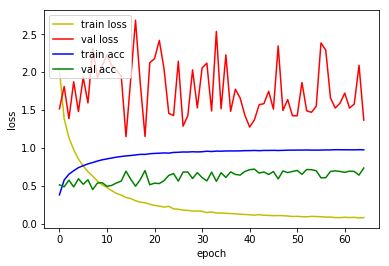

4815/4815 [==============================] - 4s 898us/sample - loss: 1.3379 - acc: 0.6422
Loss: 1.3379319469505382 Accuracy: 0.64215994

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9742 - acc: 0.3990
Epoch 00001: val_loss improved from inf to 1.38826, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_5_conv_checkpoint/001-1.3883.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 1.9741 - acc: 0.3990 - val_loss: 1.3883 - val_acc: 0.5681
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3344 - acc: 0.5964
Epoch 00002: val_loss improved from 1.38826 to 1.28925, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_5_conv_checkpoint/002-1.2893.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.3345 - acc: 0.5964 - val_loss: 1.2893 - val_acc: 0.6271
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2339 - acc: 0.9271
Epoch 00028: val_loss did not improve from 0.95671
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2339 - acc: 0.9271 - val_loss: 2.9537 - val_acc: 0.4705
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.9291
Epoch 00029: val_loss did not improve from 0.95671
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2275 - acc: 0.9291 - val_loss: 1.0421 - val_acc: 0.7333
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2205 - acc: 0.9310
Epoch 00030: val_loss did not improve from 0.95671
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2205 - acc: 0.9310 - val_loss: 1.1143 - val_acc: 0.7193
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2129 - acc: 0.9340
Epoch 00031: val_loss did not improve from 0.95671
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1115 - acc: 0.9664
Epoch 00058: val_loss did not improve from 0.95671
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1115 - acc: 0.9664 - val_loss: 2.1150 - val_acc: 0.6133
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9645
Epoch 00059: val_loss did not improve from 0.95671
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1152 - acc: 0.9645 - val_loss: 1.1209 - val_acc: 0.7531
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1113 - acc: 0.9645
Epoch 00060: val_loss did not improve from 0.95671
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1113 - acc: 0.9645 - val_loss: 1.3046 - val_acc: 0.7226
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1070 - acc: 0.9668
Epoch 00061: val_loss did not improve from 0.95671
36805/36805 [===========

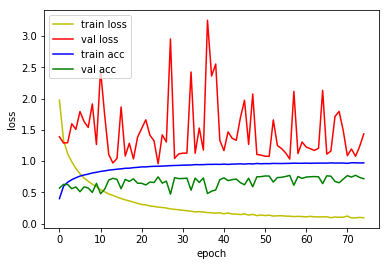

4815/4815 [==============================] - 4s 934us/sample - loss: 1.0684 - acc: 0.7082
Loss: 1.068411387288063 Accuracy: 0.70820355

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0127 - acc: 0.3833
Epoch 00001: val_loss improved from inf to 1.41030, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_6_conv_checkpoint/001-1.4103.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 2.0127 - acc: 0.3833 - val_loss: 1.4103 - val_acc: 0.5700
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4075 - acc: 0.5655
Epoch 00002: val_loss did not improve from 1.41030
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.4075 - acc: 0.5655 - val_loss: 1.4503 - val_acc: 0.5747
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1879 - acc: 0.6367
Epoch 00003: val_loss did not improve from 1.41030
36805/36805 [============

36800/36805 [============================>.] - ETA: 0s - loss: 0.3643 - acc: 0.8891
Epoch 00029: val_loss did not improve from 0.81222
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3643 - acc: 0.8891 - val_loss: 0.8597 - val_acc: 0.7538
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3527 - acc: 0.8911
Epoch 00030: val_loss did not improve from 0.81222
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3526 - acc: 0.8911 - val_loss: 1.6242 - val_acc: 0.6285
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3421 - acc: 0.8945
Epoch 00031: val_loss improved from 0.81222 to 0.74868, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_6_conv_checkpoint/031-0.7487.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3422 - acc: 0.8944 - val_loss: 0.7487 - val_acc: 0.7950
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3376 - acc

36800/36805 [============================>.] - ETA: 0s - loss: 0.1904 - acc: 0.9400
Epoch 00058: val_loss did not improve from 0.65072
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1903 - acc: 0.9400 - val_loss: 0.9363 - val_acc: 0.7710
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9410
Epoch 00059: val_loss did not improve from 0.65072
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1857 - acc: 0.9409 - val_loss: 1.2725 - val_acc: 0.7016
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1797 - acc: 0.9428
Epoch 00060: val_loss did not improve from 0.65072
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1797 - acc: 0.9427 - val_loss: 1.0285 - val_acc: 0.7605
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1791 - acc: 0.9436
Epoch 00061: val_loss did not improve from 0.65072
36805/36805 [========================

Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1226 - acc: 0.9599
Epoch 00088: val_loss did not improve from 0.65072
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1226 - acc: 0.9599 - val_loss: 1.1068 - val_acc: 0.7519
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1233 - acc: 0.9605
Epoch 00089: val_loss did not improve from 0.65072
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1233 - acc: 0.9605 - val_loss: 1.0382 - val_acc: 0.7729
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1183 - acc: 0.9631
Epoch 00090: val_loss did not improve from 0.65072
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1182 - acc: 0.9631 - val_loss: 0.7460 - val_acc: 0.8276

1D_CNN_custom_tanh_DO_BN_6_conv Model


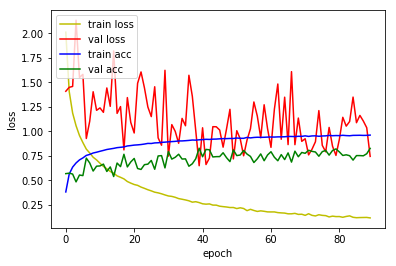

4815/4815 [==============================] - 5s 935us/sample - loss: 0.7886 - acc: 0.7859
Loss: 0.7885798440358349 Accuracy: 0.78587747

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1700 - acc: 0.3373
Epoch 00001: val_loss improved from inf to 1.63855, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_7_conv_checkpoint/001-1.6386.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 2.1700 - acc: 0.3373 - val_loss: 1.6386 - val_acc: 0.5043
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5064 - acc: 0.5356
Epoch 00002: val_loss did not improve from 1.63855
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.5064 - acc: 0.5356 - val_loss: 2.0888 - val_acc: 0.4284
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2408 - acc: 0.6176
Epoch 00003: val_loss did not improve from 1.63855
36805/36805 [==========

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3269 - acc: 0.9015
Epoch 00028: val_loss did not improve from 0.53866
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3268 - acc: 0.9016 - val_loss: 0.7359 - val_acc: 0.7908
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3241 - acc: 0.9024
Epoch 00029: val_loss did not improve from 0.53866
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3241 - acc: 0.9024 - val_loss: 0.6995 - val_acc: 0.8088
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3128 - acc: 0.9052
Epoch 00030: val_loss did not improve from 0.53866
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3128 - acc: 0.9052 - val_loss: 0.7100 - val_acc: 0.8006
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2998 - acc: 0.9104
Epoch 00031: val_loss improved from 0.53866 to 0.51907, saving model to mod

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1581 - acc: 0.9507
Epoch 00057: val_loss did not improve from 0.38048
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1582 - acc: 0.9506 - val_loss: 0.9660 - val_acc: 0.7610
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1609 - acc: 0.9508
Epoch 00058: val_loss did not improve from 0.38048
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1609 - acc: 0.9508 - val_loss: 0.4882 - val_acc: 0.8609
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1474 - acc: 0.9542
Epoch 00059: val_loss did not improve from 0.38048
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1475 - acc: 0.9542 - val_loss: 0.4176 - val_acc: 0.8861
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1552 - acc: 0.9536
Epoch 00060: val_loss did not improve from 0.38048
36805/36805 [===========

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0868 - acc: 0.9732
Epoch 00087: val_loss did not improve from 0.38048
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0868 - acc: 0.9732 - val_loss: 0.5469 - val_acc: 0.8726
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0965 - acc: 0.9696
Epoch 00088: val_loss did not improve from 0.38048
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0965 - acc: 0.9696 - val_loss: 0.4563 - val_acc: 0.8889
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9728
Epoch 00089: val_loss did not improve from 0.38048
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0878 - acc: 0.9728 - val_loss: 0.4637 - val_acc: 0.8765
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0987 - acc: 0.9686
Epoch 00090: val_loss did not improve from 0.38048
36805/36805 [===========

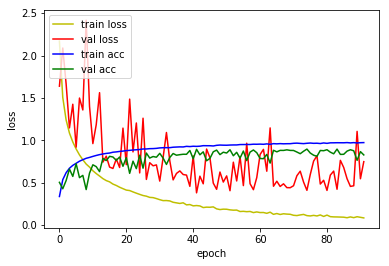

4815/4815 [==============================] - 5s 989us/sample - loss: 0.4707 - acc: 0.8687
Loss: 0.4706748081763833 Accuracy: 0.86874354

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2228 - acc: 0.3178
Epoch 00001: val_loss improved from inf to 1.69649, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_8_conv_checkpoint/001-1.6965.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 2.2227 - acc: 0.3179 - val_loss: 1.6965 - val_acc: 0.4764
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5214 - acc: 0.5259
Epoch 00002: val_loss improved from 1.69649 to 1.29243, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_8_conv_checkpoint/002-1.2924.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.5214 - acc: 0.5259 - val_loss: 1.2924 - val_acc: 0.6075
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2104 - acc: 0.9371
Epoch 00026: val_loss did not improve from 0.33014
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2104 - acc: 0.9371 - val_loss: 0.3756 - val_acc: 0.8919
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1957 - acc: 0.9418
Epoch 00027: val_loss did not improve from 0.33014
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1959 - acc: 0.9418 - val_loss: 0.4092 - val_acc: 0.8824
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2020 - acc: 0.9407
Epoch 00028: val_loss improved from 0.33014 to 0.30737, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_8_conv_checkpoint/028-0.3074.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2019 - acc: 0.9407 - val_loss: 0.3074 - val_acc: 0.9126
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0866 - acc: 0.9749
Epoch 00055: val_loss improved from 0.27007 to 0.26512, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_8_conv_checkpoint/055-0.2651.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0866 - acc: 0.9749 - val_loss: 0.2651 - val_acc: 0.9283
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0729 - acc: 0.9780
Epoch 00056: val_loss did not improve from 0.26512
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0730 - acc: 0.9780 - val_loss: 0.2899 - val_acc: 0.9255
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0722 - acc: 0.9783
Epoch 00057: val_loss did not improve from 0.26512
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0722 - acc: 0.9783 - val_loss: 0.3431 - val_acc: 0.9096
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.9849
Epoch 00084: val_loss did not improve from 0.25057
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0524 - acc: 0.9849 - val_loss: 0.2640 - val_acc: 0.9338
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9892
Epoch 00085: val_loss did not improve from 0.25057
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0380 - acc: 0.9892 - val_loss: 0.2597 - val_acc: 0.9352
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9904
Epoch 00086: val_loss did not improve from 0.25057
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0337 - acc: 0.9904 - val_loss: 0.3689 - val_acc: 0.9108
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9884
Epoch 00087: val_loss did not improve from 0.25057
36805/36805 [===========

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9930
Epoch 00113: val_loss did not improve from 0.23312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0247 - acc: 0.9930 - val_loss: 0.3188 - val_acc: 0.9273
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9914
Epoch 00114: val_loss did not improve from 0.23312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0285 - acc: 0.9914 - val_loss: 0.3151 - val_acc: 0.9276
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9932
Epoch 00115: val_loss did not improve from 0.23312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0247 - acc: 0.9932 - val_loss: 0.3339 - val_acc: 0.9231
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9930
Epoch 00116: val_loss did not improve from 0.23312
36805/36805 [=======

Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9967
Epoch 00143: val_loss did not improve from 0.23312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0117 - acc: 0.9967 - val_loss: 0.3131 - val_acc: 0.9324
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9957
Epoch 00144: val_loss did not improve from 0.23312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0150 - acc: 0.9957 - val_loss: 0.2969 - val_acc: 0.9364
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9925
Epoch 00145: val_loss did not improve from 0.23312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0248 - acc: 0.9925 - val_loss: 0.3009 - val_acc: 0.9364
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9929
Epoch 00146: val_loss did not improve from 0.23312
36805/36805 [=======

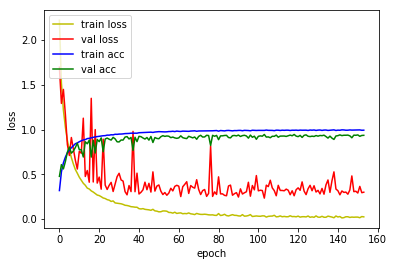

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3082 - acc: 0.9252
Loss: 0.3082310465745713 Accuracy: 0.92523366

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9139 - acc: 0.4125
Epoch 00001: val_loss improved from inf to 1.17872, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_9_conv_checkpoint/001-1.1787.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.9139 - acc: 0.4125 - val_loss: 1.1787 - val_acc: 0.6250
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1234 - acc: 0.6552
Epoch 00002: val_loss improved from 1.17872 to 1.11756, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_9_conv_checkpoint/002-1.1176.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.1234 - acc: 0.6552 - val_loss: 1.1176 - val_acc: 0.6599
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9752
Epoch 00025: val_loss did not improve from 0.19071
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0848 - acc: 0.9751 - val_loss: 0.2034 - val_acc: 0.9425
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9759
Epoch 00026: val_loss did not improve from 0.19071
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0824 - acc: 0.9759 - val_loss: 0.2717 - val_acc: 0.9203
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0853 - acc: 0.9754
Epoch 00027: val_loss improved from 0.19071 to 0.18990, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_BN_9_conv_checkpoint/027-0.1899.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0853 - acc: 0.9754 - val_loss: 0.1899 - val_acc: 0.9415
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9957
Epoch 00082: val_loss did not improve from 0.17131
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0146 - acc: 0.9957 - val_loss: 0.2005 - val_acc: 0.9497
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9946
Epoch 00083: val_loss did not improve from 0.17131
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0180 - acc: 0.9946 - val_loss: 0.1969 - val_acc: 0.9506
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9981
Epoch 00084: val_loss did not improve from 0.17131
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0082 - acc: 0.9981 - val_loss: 0.2570 - val_acc: 0.9406
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9955
Epoch 00085: val_loss did not improve from 0.17131
36805/36805 [========================

Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9984
Epoch 00141: val_loss did not improve from 0.16862
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0055 - acc: 0.9984 - val_loss: 0.2191 - val_acc: 0.9581
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9985
Epoch 00142: val_loss did not improve from 0.16862
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0055 - acc: 0.9985 - val_loss: 0.1826 - val_acc: 0.9585
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9974
Epoch 00143: val_loss did not improve from 0.16862
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0088 - acc: 0.9974 - val_loss: 0.2428 - val_acc: 0.9429
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9982
Epoch 00144: val_loss did not improve from 0.16862
36805/36805 [=======

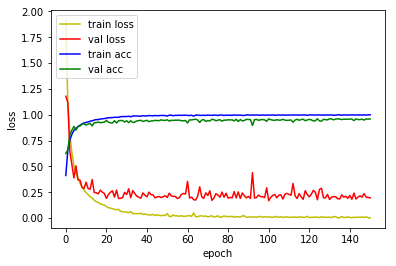

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2464 - acc: 0.9479
Loss: 0.24635794292497115 Accuracy: 0.9478712



In [10]:
base = '1D_CNN_custom_tanh_DO_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_BN_1_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         


4815/4815 [==============================] - 4s 860us/sample - loss: 1.3379 - acc: 0.6422
Loss: 1.3379319469505382 Accuracy: 0.64215994

1D_CNN_custom_tanh_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (Non

4815/4815 [==============================] - 5s 975us/sample - loss: 0.4707 - acc: 0.8687
Loss: 0.4706748081763833 Accuracy: 0.86874354

1D_CNN_custom_tanh_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (Non

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2464 - acc: 0.9479
Loss: 0.24635794292497115 Accuracy: 0.9478712


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_______________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.5630 - acc: 0.6870
Loss: 1.5629845671935987 Accuracy: 0.6870197

1D_CNN_custom_tanh_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.9488 - acc: 0.7774
Loss: 0.948824455284998 Accuracy: 0.7773624

1D_CNN_custom_tanh_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 1

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2553 - acc: 0.9470
Loss: 0.2552510752863911 Accuracy: 0.9470405
